## **Pendahuluan**

Pada praktikum ini, kita akan membangun sebuah model klasifikasi gambar menggunakan TensorFlow dan Keras.
Model ini akan digunakan untuk mengklasifikasikan gambar menjadi tiga kategori: **Rock, Paper, dan Scissors**.

Agar proses pelatihan menjadi lebih efisien dan cepat, kita akan memanfaatkan teknik **Transfer Learning** dengan menggunakan model pre-trained **MobileNetV2** sebagai feature extractor.

### **Dataset**

Dataset yang digunakan dalam praktikum ini berasal dari Kaggle, dan dapat diunduh melalui tautan berikut:

🔗 [Rock-Paper-Scissors Dataset – Kaggle](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors)

Setelah mendownload dataset dan mengekstraknya, **praktikan diwajibkan** untuk menyusun struktur folder dataset menjadi seperti berikut:

<pre>
dataset/
    rock/
    paper/
    scissor/
</pre>



### **Load Dataset**
---

Kode di bawah ini digunakan untuk memuat dataset citra dari struktur folder yang telah disiapkan sebelumnya.

Praktikan diminta untuk:

- Menentukan **ukuran gambar** (`img_size`) sesuai dengan model yang akan digunakan (misalnya 224x224 untuk MobileNetV2).
- Mengatur **ukuran batch** (`batch_size`) sesuai kapasitas RAM/VRAM masing-masing.
- Mengisi nilai **`seed`** untuk memastikan bahwa hasil pembagian data bisa direproduksi kembali dengan urutan yang sama setiap kali dijalankan.

Dataset akan dibagi menjadi tiga bagian:
- **Training set**: 70%
- **Validation set**: 15%
- **Testing set**: 15%

Proses pemuatan data dilakukan dengan menggunakan fungsi bawaan TensorFlow, yaitu `image_dataset_from_directory()`, yang akan secara otomatis membaca gambar berdasarkan nama subfoldernya sebagai label.

> **Catatan:**
> Praktikan diperbolehkan untuk **menyesuaikan sendiri persentase pembagian data** (misalnya 80% train, 10% val, 10% test) selama proporsinya tetap konsisten dan masuk akal.  
> Praktikan juga dapat mengubah **ukuran gambar (`img_size`)** jika ingin menggunakan arsitektur model yang berbeda, serta **mengganti nilai `seed`** untuk mencoba hasil pembagian data yang berbeda.

Setelah training set dan validation+test set dimuat, validation dan test akan dipisahkan secara manual berdasarkan fraksi yang telah ditentukan.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import os

# === PARAMETER YANG HARUS DITENTUKAN PRAKTIKAN ===
dataset_dir = "dataset"       # folder utama dataset
img_size    = (224, 224)      # ukuran gambar (sesuai dengan MobileNetV2)
batch_size  = 32              # ukuran batch
seed        = 42              # random seed untuk reproducibility

# Dapatkan daftar kelas dari folder
classes = sorted(os.listdir(dataset_dir))

# === ATURAN SPLIT DATA ===
train_frac = 0.70
val_frac   = 0.15
test_frac  = 0.15
vt_frac    = val_frac + test_frac   # val + test (untuk split manual nanti)

# === MEMUAT TRAIN DATASET ===
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",        # gunakan one-hot encoding
)

# === MEMUAT VALIDATION + TEST DATASET (gabungan) ===
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=vt_frac,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical",
)

# === SPLIT VAL DAN TEST SECARA MANUAL ===
vt_batches  = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = int(vt_batches * (val_frac / vt_frac))   # hitung proporsi val dalam val+test

val_ds  = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

# === CETAK INFORMASI DATASET ===
print(f"Total kelas: {len(classes)}")
print(f"Total batch train: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Total batch val: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Total batch test: {tf.data.experimental.cardinality(test_ds).numpy()}")

print("\nContoh kelas:", classes)


Found 2188 files belonging to 3 classes.
Using 1532 files for training.
Found 2188 files belonging to 3 classes.
Using 656 files for validation.
Total kelas: 3
Total batch train: 48
Total batch val: 10
Total batch test: 11

Contoh kelas: ['paper', 'rock', 'scissors']


### **Preprocessing dan Augmentasi Data**
---

Sebelum gambar dapat digunakan untuk melatih model, dataset perlu melalui proses **preprocessing** terlebih dahulu. Preprocessing ini bertujuan untuk memastikan bahwa semua input gambar berada dalam skala nilai yang konsisten dan sesuai dengan ekspektasi dari model.

Pada praktikum ini, preprocessing dilakukan melalui dua tahap:

1. **Normalisasi**:  
   Setiap pixel gambar yang awalnya berada pada rentang nilai **[0, 255]** diubah ke rentang **[0, 1]** dengan menggunakan layer `Rescaling(1./255)`.

2. **Augmentasi** (opsional):  
   Untuk meningkatkan variasi data dan mengurangi overfitting, dilakukan augmentasi pada **data training saja**. Augmentasi dilakukan melalui transformasi berikut:
   - `RandomFlip("horizontal")`: membalik gambar secara horizontal.
   - `RandomRotation(0.1)`: memutar gambar secara acak hingga 10%.
   - `RandomZoom(0.1, 0.1)`: melakukan zoom in/out hingga 10%.
   - `RandomContrast(0.1)`: mengubah kontras gambar secara acak hingga ±10%.

Semua preprocessing dan augmentasi dilakukan melalui fungsi `prep()`.  
Fungsi ini menerima parameter `augment` untuk menentukan apakah augmentasi akan diterapkan atau tidak.  
- Jika `augment=True`, maka data akan dinormalisasi lalu diaugmentasi.  
- Jika `augment=False`, maka hanya normalisasi yang dilakukan (untuk validation dan test set).

Setelah diproses, setiap dataset akan di-cache dan di-prefetch menggunakan `AUTOTUNE` untuk mengoptimalkan performa saat training.

> **Catatan untuk praktikan:**  
> Praktikan dapat menyesuaikan jenis dan tingkat augmentasi pada `aug_layer` untuk melihat pengaruhnya terhadap performa model. Namun, augmentasi **hanya boleh diterapkan pada training set**.


In [5]:
from tensorflow.keras import layers

# === NORMALISASI (PREPROCESSING) ===
norm_layer = tf.keras.Sequential([
    layers.Rescaling(1./255),  # normalisasi ke [0,1]
])

# === AUGMENTASI (HANYA UNTUK TRAINING) ===
aug_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),    # flip kiri-kanan
    layers.RandomRotation(0.1),         # rotasi ±10%
    layers.RandomZoom(0.1, 0.1),        # zoom in/out sampai 10%
    layers.RandomContrast(0.1),         # kontras ±10%
])

# === FUNGSI PREPROCESSING ===
def prep(ds, augment=False):
    if augment:
        # augmentasi hanya untuk training
        ds = ds.map(lambda x, y: (aug_layer(norm_layer(x), training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # hanya normalisasi untuk validation dan test
        ds = ds.map(lambda x, y: (norm_layer(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    
    # caching untuk mempercepat training
    return ds.cache().prefetch(tf.data.AUTOTUNE)

# === APLIKASIKAN PREPROCESSING DAN AUGMENTASI ===
train_ds = prep(train_ds, augment=True)   # augmentasi diaktifkan
val_ds   = prep(val_ds,   augment=False)  # hanya normalisasi
test_ds  = prep(test_ds,  augment=False)  # hanya normalisasi

# === CETAK INFORMASI DATASET ===
print(f"Train dataset: {train_ds}")
print(f"Validation dataset: {val_ds}")
print(f"Test dataset: {test_ds}")


Train dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Validation dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
Test dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


### **Build Model dan Training**
---

Pada tahap ini, kita akan membangun arsitektur model menggunakan teknik **Transfer Learning** dengan memanfaatkan **MobileNetV2** sebagai feature extractor.

Praktikan diminta untuk:

- **Melengkapi input layer** (`inputs`) dengan ukuran shape gambar yang sesuai.
- **Melengkapi output layer** (`outputs`) dengan jumlah neuron yang sama dengan jumlah kelas target (jumlah kategori pada dataset).

Bagian head klasifikasi model disusun dengan struktur:

- **GlobalAveragePooling2D**: Mengubah output feature map menjadi satu vektor rata-rata per channel.
- **Dropout**: Teknik regularisasi untuk mengurangi overfitting.
- **Dense (Softmax)**: Layer output yang mengklasifikasikan input ke dalam salah satu kelas.

---

### **Training Model**

Sebelum memulai proses pelatihan, kita juga telah mendefinisikan dua buah callbacks:

- `EarlyStopping`: Untuk menghentikan pelatihan jika validation loss tidak membaik setelah sejumlah epoch tertentu.
- `ModelCheckpoint`: Untuk menyimpan model terbaik berdasarkan validation loss.

Praktikan diminta untuk:

- **Melengkapi list callbacks** di fungsi `model.fit()`, dengan menambahkan kedua callbacks yang telah dibuat sebelumnya (`early_stopping` dan `model_checkpoint`).
- Menjalankan training selama **50 epoch** atau hingga proses berhenti otomatis karena `EarlyStopping`.

> **Catatan:**  
> Dengan menggunakan callbacks, kita dapat menghindari overfitting dan memastikan model terbaik tersimpan otomatis.



In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2

# Load pre-trained base model
base_model = MobileNetV2(
    input_shape=(*img_size, 3),  # menggunakan img_size yang sudah didefinisikan sebelumnya
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base model

# === DEFINISI MODEL (HEAD KLASIFIKASI) ===
# Tentukan input dan output sesuai jumlah kelas pada dataset
inputs = tf.keras.Input(shape=(*img_size, 3))  # ukuran input sesuai img_size, dengan 3 channel (RGB)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)  # mengubah feature map menjadi vektor rata-rata per channel
x = layers.Dropout(0.2)(x)  # regularisasi untuk mencegah overfitting
outputs = layers.Dense(len(classes), activation="softmax")(x)  # jumlah output neuron sesuai jumlah kelas
model = models.Model(inputs, outputs)

# === KOMPILE MODEL ===
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# === CALLBACKS ===
early_stopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)
model_checkpoint = callbacks.ModelCheckpoint(
    "best_transfer.keras",  # gunakan format .keras
    monitor="val_loss",
    save_best_only=True
)


# === TRAINING MODEL ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]  # tambahkan callbacks
)

# === CETAK RINGKASAN MODEL ===
model.summary()


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 23s 387ms/step - accuracy: 0.7143 - loss: 0.6717 - val_accuracy: 0.9781 - val_loss: 0.1144
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.9617 - loss: 0.1461 - val_accuracy: 0.9875 - val_loss: 0.0633
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.9805 - loss: 0.0900 - val_accuracy: 0.9906 - val_loss: 0.0466
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.9888 - loss: 0.0607 - val_accuracy: 0.9937 - val_loss: 0.0370
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.9910 - loss: 0.0479 - val_accuracy: 0.9937 - val_loss: 0.0323
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - accuracy: 0.9910 - loss: 0.0426 - val_accuracy: 0.9937 - val_loss: 0.0288
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 304ms/step - accuracy: 0.9933 - loss: 0.0351 - val_accuracy: 0.9937 - val_loss: 0.0260
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 306ms/step - accuracy: 0.9970 - loss: 0.0301 - val_accu

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,515 (8.66 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 7,688 (30.04 KB)

### **Evaluasi Model**
---

Setelah model selesai dilatih, langkah berikutnya adalah mengevaluasi performanya pada **test set**.

Evaluasi dilakukan menggunakan dua pendekatan utama:

1. **Classification Report**  
   Menampilkan metrik klasifikasi seperti:
   - **Precision**: Seberapa akurat model saat membuat prediksi positif.
   - **Recall**: Seberapa baik model menangkap semua sampel positif.
   - **F1-Score**: Harmoni antara precision dan recall.
   - **Accuracy**: Persentase prediksi yang benar dari semua prediksi.

2. **Confusion Matrix**  
   Menunjukkan jumlah prediksi benar dan salah untuk masing-masing kelas, dalam bentuk tabel.  
   Dengan confusion matrix, kita bisa melihat pola kesalahan model (misal, apakah model sering salah membedakan "rock" dengan "paper", dll).

---

#### Langkah-langkah yang dilakukan pada kode:

- Menggunakan model untuk melakukan prediksi pada seluruh test dataset.
- Membandingkan hasil prediksi dengan label asli.
- Menampilkan classification report menggunakan `classification_report` dari scikit-learn.
- Menghitung dan memvisualisasikan confusion matrix menggunakan `ConfusionMatrixDisplay`.

> **Catatan untuk praktikan:**  
> Perhatikan nilai **precision**, **recall**, dan **f1-score** dari masing-masing kelas.  
> Jika terdapat ketidakseimbangan performa antar kelas, analisis kemungkinan penyebabnya (misalnya karena jumlah data tidak seimbang, kesamaan visual antar kelas, dsb).


11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step
=== Classification Report ===
              precision    recall  f1-score   support

       paper     0.9882    0.9655    0.9767        87
        rock     0.9919    0.9919    0.9919       124
    scissors     0.9764    0.9920    0.9841       125

    accuracy                         0.9851       336
   macro avg     0.9855    0.9832    0.9843       336
weighted avg     0.9852    0.9851    0.9851       336



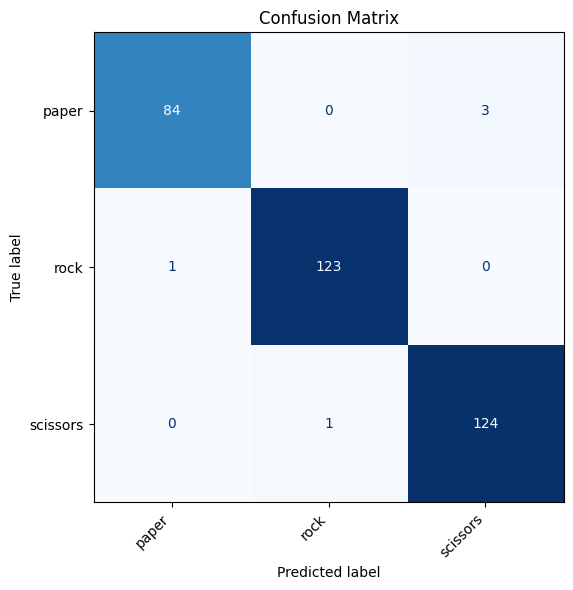

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# dapatkan prediksi probabilitas dan label dari test set
y_pred_probs = model.predict(test_ds)               # shape = (N, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)             # ambil indeks prediksi tertinggi (shape: (N,))

# ekstrak label asli dari test_ds
#    Karena test_ds bertipe (x_batch, y_batch) dengan label one-hot, kita ambil argmax dari y_batch
y_true = np.concatenate([
    np.argmax(y.numpy(), axis=1)
    for _, y in test_ds
], axis=0)

# tampilkan classification report
print("=== Classification Report ===")
print(classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
))

# hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Setelah proses pelatihan selesai, model yang telah dilatih akan secara otomatis disimpan oleh callback `ModelCheckpoint` ke dalam file `.h5`.

Model ini dapat langsung digunakan dalam pengembangan aplikasi backend yang menggunakan **FastAPI** atau frontend berbasis **Streamlit**, untuk membuat aplikasi klasifikasi gambar.